In [1]:
def clip(tmp1):
    import subprocess
    import shlex  # 导入 shlex 模块
    # 使用 shlex.quote 来转义 inp 字符串
    tmp2 = str(tmp1)
    safe_str = shlex.quote(tmp2)
    subprocess.run('echo {} | wclip'.format(safe_str), shell=True)  

def cvin(k):
    clip(In[k])
    
import numpy as np
import matplotlib.pyplot as plt

import time 
#from tqdm import tqdm  # tqdm是显示循环进度条的库
from tqdm.notebook import tqdm #推荐在jupyter中使用自带的进度条
import copy #复制方法

#-------------------------------------------------------------------
np.random.seed(0) #重置种子为0
np.set_printoptions(precision=3, suppress=True, linewidth=100)#格式化输出
#-------------------------------------------------------------------

import rl_utils
import random
import gymnasium as gym
import collections
import torch
import torch.nn.functional as F
import os

import torch

#### Q-learning->DQN
这种用表格Qsa存储动作价值的做法只在环境的状态和动作都是离散的，并且空间都比较小的情况下适用，比如悬崖漫步，当状态比较大的时候，只能用价值函数：
DQN（Deep Q-Network）是Q-learning的一个扩展，它使用了深度学习。从Q-learning到DQN的转换涉及到几个关键的步骤和思想。以下是一个简明的概述：

1. 函数逼近器:
- Q-learning: 使用表格存储Qsa
- DQN: 使用一个神经网络作为函数逼近器来估计Q值(非连续)


2. 经验回放 (Experience Replay):
- DQN不立即使用每一步的经验来更新其Q值，而是将其存储在一个经验池中。随后，从这个经验池中随机抽取一个批量的经验来更新网络。
- 这打破数据之间的相关性，使得学习过程更加稳定

3. 目标网络:
- Q-learning中，使用当前的Q值估计来更新Q值
- DQN中，这会导致学习过程不稳定，因为我们同时在尝试估计和更新同一个网络
因此DQN使用了两个网络：一个主网络和一个目标网络(在固定的时间间隔内保持不变）


4. 更复杂的神经网络结构:
对于图像输入DQN通常使用卷积神经网络 (CNN) 作为其函数逼近器。

随着时间的推移，对DQN的许多改进和变种已经被提出：如Double DQN、Prioritized Experience Replay、Dueling DQN等，以进一步提高性能。








## DQN
> **通常 DQN（以及 Q-learning）只能处理动作离散的情况，因为在函数的更新过程中有$max_a$这一操作**

DQN使用参数化的函数$Q_{\theta}$来拟合这些数据。很显然，这种函数拟合的方法存在一定的精度损失，因此被称为近似方法。
如下用来解决连续状态下离散动作的问题：

### 1.CartPole环境
状态值就是连续的，动作值是离散的
在车杆环境中，有一辆小车，智能体的任务是通过左右移动保持车上的杆竖直：
- 若杆的倾斜度数过大
- 车子离初始位置左右的偏离程度过大
- 坚持时间到达 200 帧

则游戏结束。
以下是将给定的数据转换为Markdown格式的表格，并将其全部输出在代码块中：

- 表 7-1 CartPole环境的状态空间
| 维度 | 意义         | 最小值   | 最大值   |
|------|--------------|---------|---------|
| 0    | 车的位置     | -2.4    | 2.4     |
| 1    | 车的速度     | -Inf    | Inf     |
| 2    | 杆的角度     | ~ -41.8°| ~ 41.8° |
| 3    | 杆尖端的速度 | -Inf    | Inf     |

- 表7-2 CartPole环境的动作空间
| 标号 | 动作         |
|------|--------------|
| 0    | 向左移动小车 |
| 1    | 向右移动小车 |

---

### 2.DQN解决思路
常见的解决方法便是使用 **函数拟合（function approximation）** 的思想：
- 若动作无限：输入(s,a)，输出一个标量Q(s,a)
- 若动作有限：只输入s，输出每一个动作Q(s,a)

设$\omega$为神经网络用来拟合函数的参数，则表示为：$Q_{\omega}(s,a)$,我们将用于拟合函数函数的神经网络称为 **Q 网络**

**|Q网络损失函数**：从 **时序差分 (temporal difference，TD)** 学习目标 $r+\gamma \max _{a^{\prime} \in \mathcal{A}} Q\left(s^{\prime}, a^{\prime}\right)$ 来增量式更新 $Q(s, a)$ :
$$
Q\left(s_{t}, a_{t}\right) \leftarrow Q\left(s_{t}, a_{t}\right)+\alpha\left[R_{t}+\gamma \max _{a} Q\left(s_{t+1}, a\right)-Q\left(s_{t}, a_{t}\right)\right]
$$
也就是说要使 $Q(s, a)$ 和 TD 目标 $r+\gamma \max _{a^{\prime} \in \mathcal{A}} Q\left(s^{\prime}, a^{\prime}\right)$ 靠近。于是，对于一组数据 $\left\{\left(s_{i}, a_{i}, r_{i}, s_{i}^{\prime}\right)\right\}$ ，我们可以很自然地将 \mathrm{Q} 网络的损失函数构造为均方误差的形式:
$$
\omega^{*}=\arg \min _{\omega} \frac{1}{2 N} \sum_{i=1}^{N}\left[Q_{\omega}\left(s_{i}, a_{i}\right)-\left(r_{i}+\gamma \max _{a^{\prime}} Q_{\omega}\left(s_{i}^{\prime}, a^{\prime}\right)\right)\right]^{2}
$$

就可以将 Q-learning 扩展到神经网络形式—— **深度 Q 网络（deep Q network，DQN）** 算法。由于 DQN 是离线策略算法，同样需要$\epsilon$-贪婪策略来平衡利用&探索，并把数据收集起来。
DQN 中还有两个非常重要的模块——经验回放和目标网络：

#### A-经验回放
Q-learning 算法中，每一个数据只会用来更新一次Q，而"放回池"——DQN 算法采用了 **经验回放（experience replay）**，具体做法为维护一个**回放缓冲区**，作用有：
1. 使样本满足独立假设：非独立同分布的数据对训练神经网络有很大的影响，会产生过拟合，采用经验回放可以打破样本之间的相关性，让其满足独立假设
2. 提高样本效率：每一个样本可以被使用多次

#### B-目标网络
方法就是分离正常梯度下降方法来进行更新的$Q_{\omega}(s_{i}, a_{i})$，和 **目标网络**计算损失函数的$(r_{i}+\gamma \max _{a^{\prime}} Q_{\omega}^-(s_{i}^{\prime}, a^{\prime}))$的$Q_{\omega}^-(s_{i}^{\prime}, a^{\prime})$，然后间隔C步后，再同步一次$\omega^-\leftarrow\omega$

#### 算法流程如下：
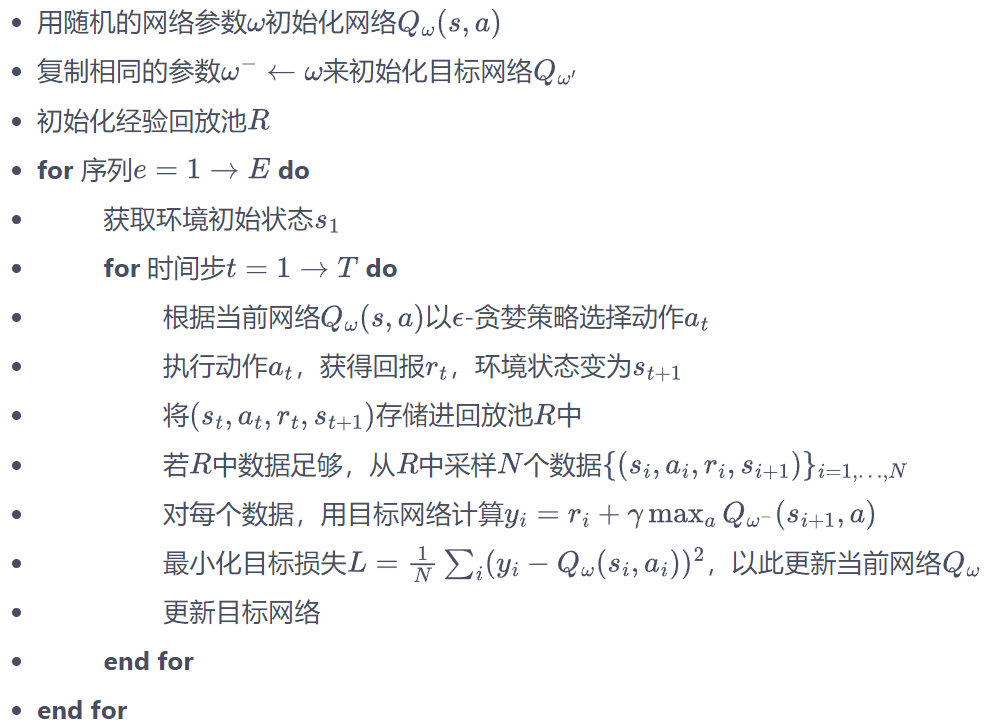

---


### 3.DQN代码实践

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done, truncated):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done, truncated))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
#>random.sample()随机采样
        state, action, reward, next_state, done, truncated = zip(*transitions)
#>用zip方法打包为元组
        return np.array(state), action, reward, np.array(next_state), done, truncated  # 多返回了一个state(

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

### Dueling Q

In [4]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        A = self.fc_A(x)
        V = self.fc_V(x)
        Q = V + A - A.mean(-1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

In [5]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, 
                 learning_rate, gamma, epsilon, 
                 target_update, device,dqn_type = 'DQN'): #学习率：决定了参数更新的步长
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  #======># Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                  self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
            # 目标网络
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device
        #记录类型
        self.dqn_type = dqn_type

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            #state_np = np.array([state])
            #state = torch.tensor(state_np, dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
#>使用.argmax()返回输出，然后用.item()返回为python可用
        return action

    def update(self, transition_dict): #transition_dict是是从回放缓冲区中采样得到的一批经验
        states = torch.tensor(np.array(transition_dict['states']),
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], 
                                dtype=torch.int64).view(-1, 1).to(self.device)
                                #👆必须torch.int64
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.int).view(-1, 1).to(self.device)
#>bug修复
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN' or 'DuelingDQN':  # 先在q网络确定动作, 再对应到目标网络的价值上
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        #>旧式样q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        #>q_targets = rewards + self.gamma * max_next_q_values * (1 - (dones | truncated))  
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones | truncated)
        #+++++++++++++++++++++++++++++++++++++++++++++++++++++
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播
        self.optimizer.step() #更新参数
        #+++++++++++++++++++++++++++++++++++++++++++++++++++++
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1        

### 会将这一训练过程包装进rl_utils库中，方便之后要学习的算法的代码实现

### 初始化参数

In [6]:
# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='rgb_array')

# 迭代相关
total_epoch = 20  # 迭代数
s_epoch = 0 # 默认开始位置
total_episode = 100  # 每次迭代最大游戏轮数
#num_episodes = 500
#minimal_size = 500
#batch_size = 64

#最佳分数相关
max_step = 500
best_score = 0  # 每回合中的最佳分数
best_weight = 0

#缓冲区相关
buffer_size = 10000  # 经验大小
minimal_size = 1000  # 最小经验数
batch_size = 128
replay_buffer = ReplayBuffer(buffer_size)
#return_list = [] #用read_ckp取代了

#DQN相关
gamma = 0.98
epsilon = 1  # 刚开始随机动作,更新中线性降低
target_update = 20  # 若干回合更新一次目标网络
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# 神经网络相关
lr = 2e-3
hidden_dim = 128
state_dim = env.observation_space.shape[0]  # 状态空间大小
action_dim = env.action_space.n  # 动作空间大小
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update,device,'DuelingDQN')

# 随机数种子
#env.seed(0) #会出问题
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### 检查点函数

In [7]:
def read_ckp(CKP_PATH):
    if os.path.exists(CKP_PATH):
        checkpoint = torch.load(CKP_PATH)
        return {
            'epoch': checkpoint.get('epoch', 0), #强行多轮训练
            'episode': checkpoint.get('episode', 0),
            'epsilon': checkpoint.get('epsilon', 1),
            'best_weight': checkpoint.get('best_weight', None),
            'return_list': checkpoint.get('return_list', [])
        }
    else:
        # 创建路径所需的文件夹
        os.makedirs(os.path.dirname(CKP_PATH), exist_ok=True)
        return {
            'epoch': 0,
            'episode': 0,
            'epsilon': 1,
            'best_weight': None,
            'return_list': []
        }

def save_ckp(data, PATH):
    os.makedirs(os.path.dirname(PATH), exist_ok=True)  # 确保路径存在
    torch.save(data, PATH)

### 读取检查点

In [8]:
CKP_PATH = 'tmp/1T_DuelingDQN.pt'
checkpoint_data = read_ckp(CKP_PATH)

s_epoch = checkpoint_data['epoch']
s_episode = checkpoint_data['episode']
epsilon = checkpoint_data['epsilon']
best_weight = checkpoint_data['best_weight']
return_list = checkpoint_data['return_list']

if best_weight is not None:
    agent.q_net.load_state_dict(best_weight)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

### 训练

<1/20>:   0%|          | 0/100 [00:00<?, ?it/s]

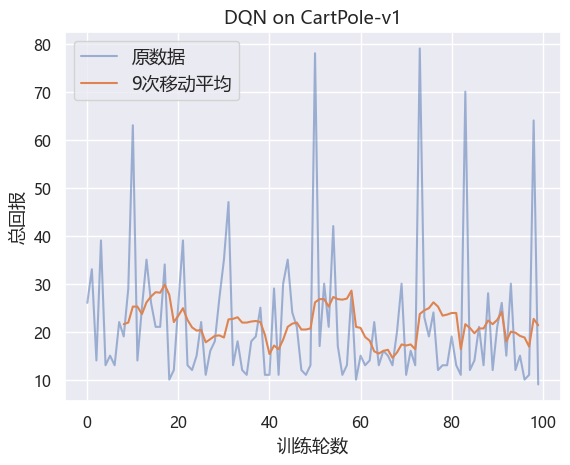

<2/20>:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\zmr233\AppData\Local\Temp\ipykernel_40916\1072975482.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)


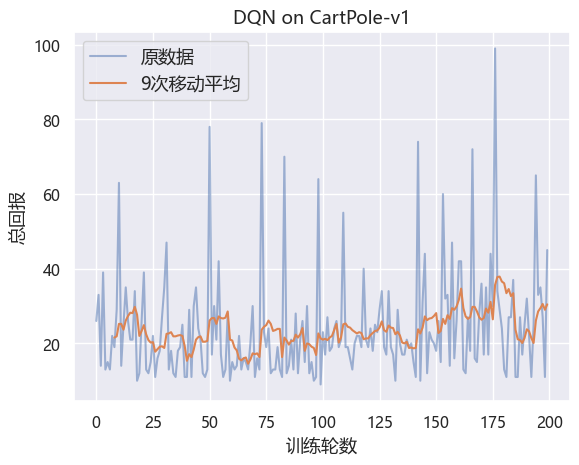

<3/20>:   0%|          | 0/100 [00:00<?, ?it/s]

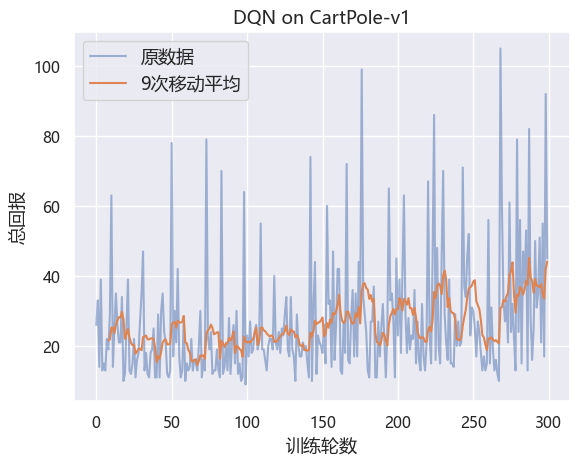

<4/20>:   0%|          | 0/100 [00:00<?, ?it/s]

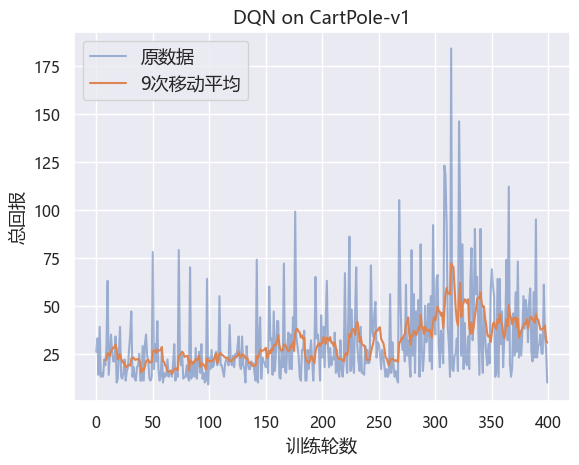

<5/20>:   0%|          | 0/100 [00:00<?, ?it/s]

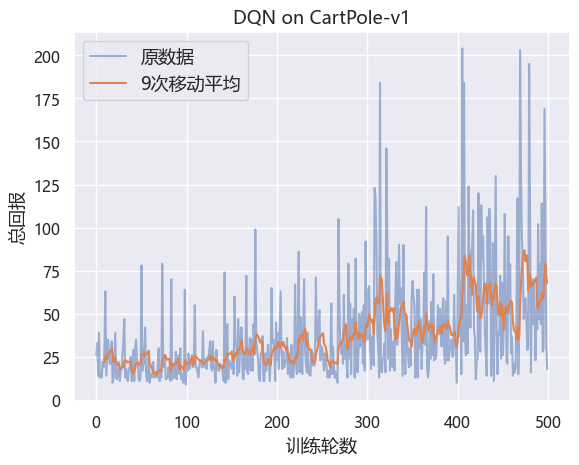

<6/20>:   0%|          | 0/100 [00:00<?, ?it/s]

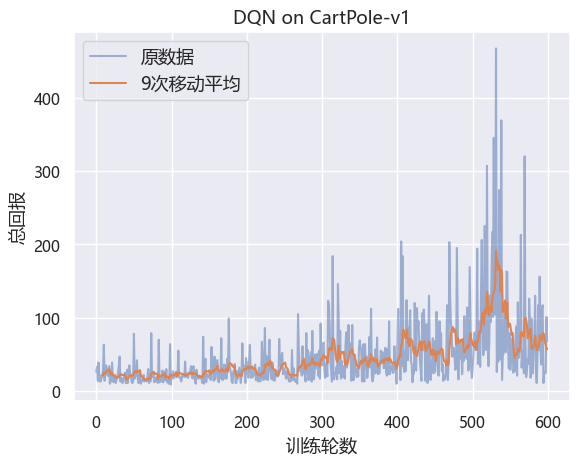

<7/20>:   0%|          | 0/100 [00:00<?, ?it/s]

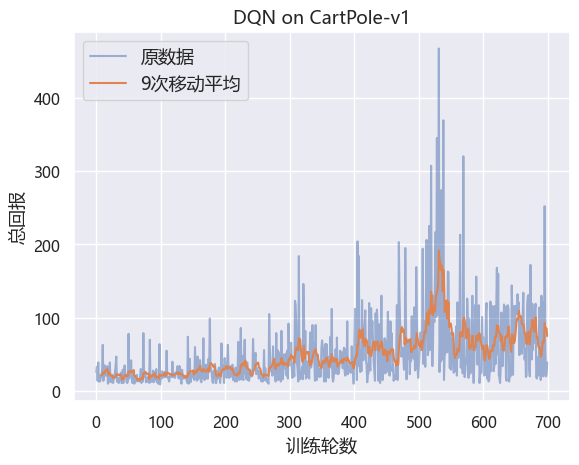

<8/20>:   0%|          | 0/100 [00:00<?, ?it/s]

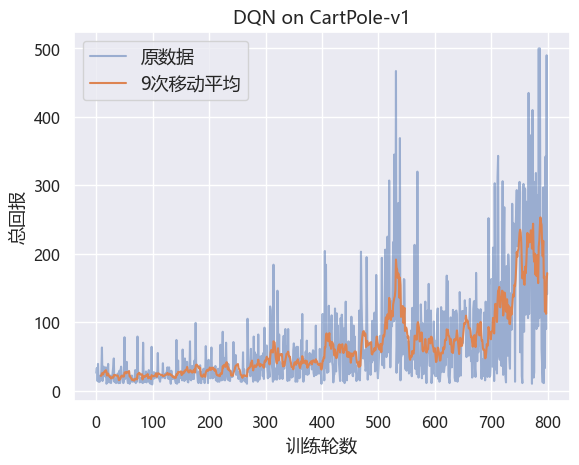

<9/20>:   0%|          | 0/100 [00:00<?, ?it/s]

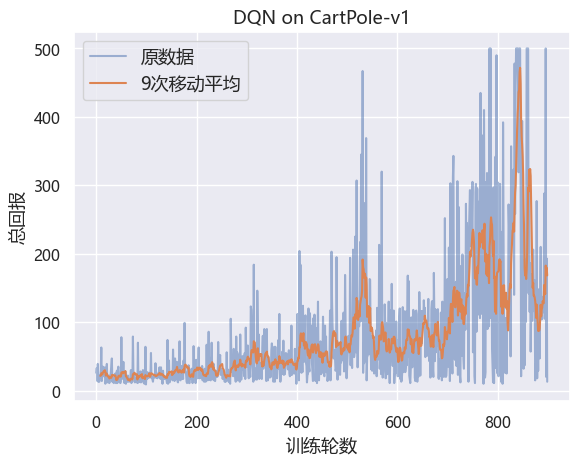

<10/20>:   0%|          | 0/100 [00:00<?, ?it/s]

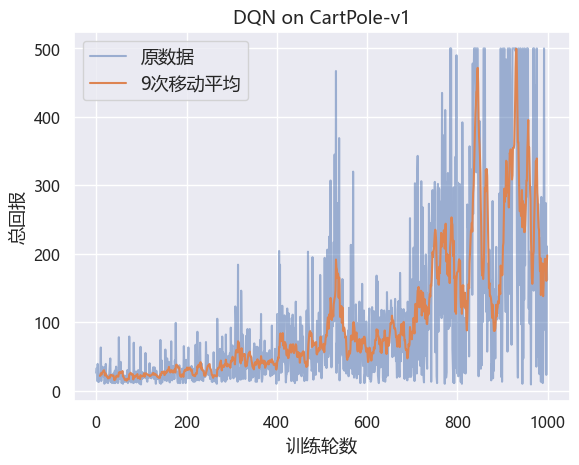

<11/20>:   0%|          | 0/100 [00:00<?, ?it/s]

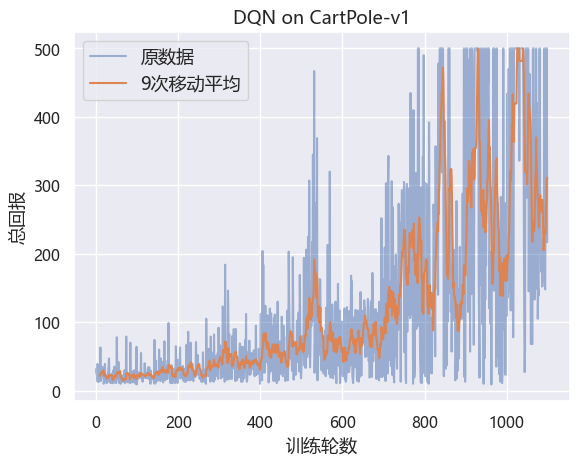

<12/20>:   0%|          | 0/100 [00:00<?, ?it/s]

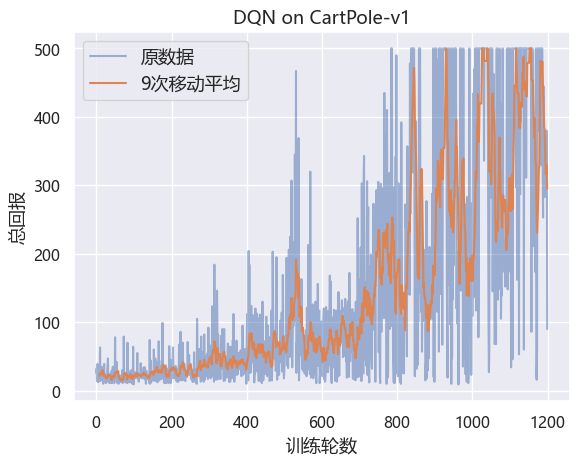

<13/20>:   0%|          | 0/100 [00:00<?, ?it/s]

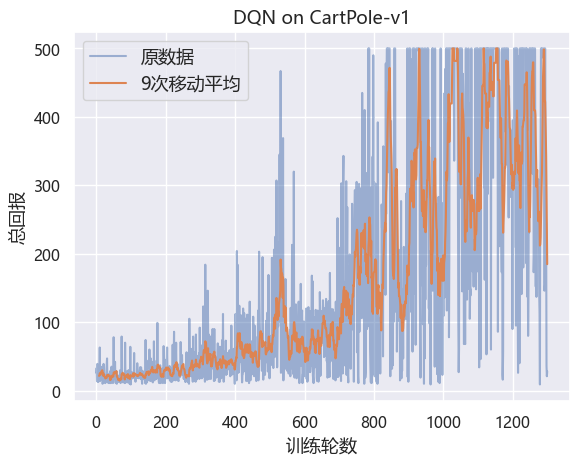

<14/20>:   0%|          | 0/100 [00:00<?, ?it/s]

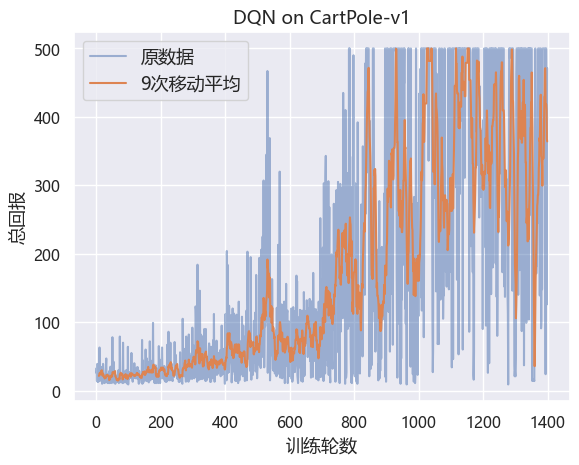

<15/20>:   0%|          | 0/100 [00:00<?, ?it/s]

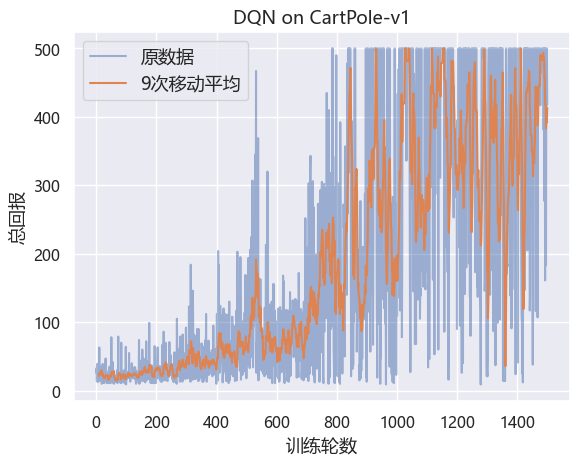

<16/20>:   0%|          | 0/100 [00:00<?, ?it/s]

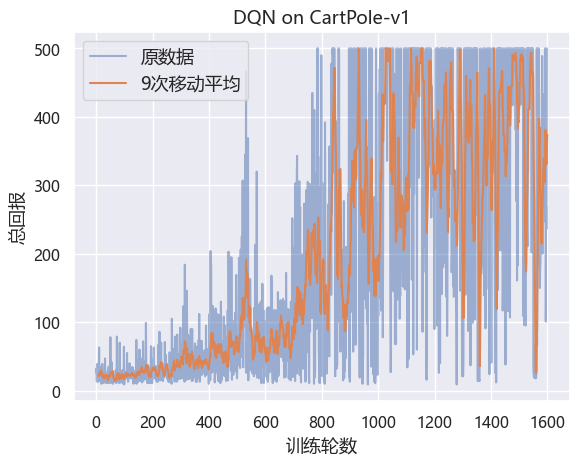

<17/20>:   0%|          | 0/100 [00:00<?, ?it/s]

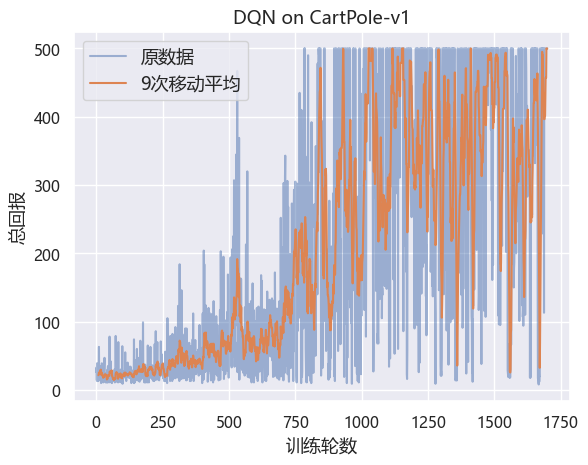

<18/20>:   0%|          | 0/100 [00:00<?, ?it/s]

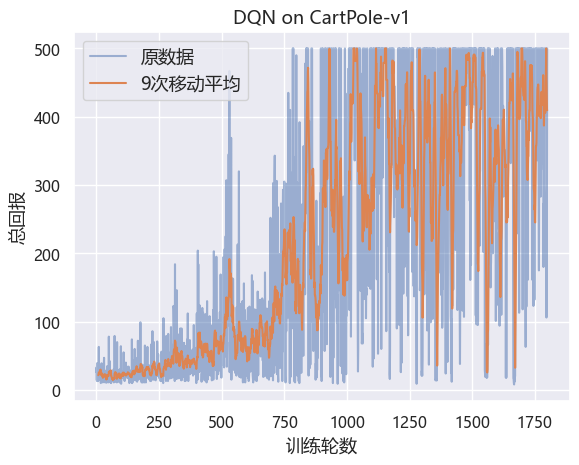

<19/20>:   0%|          | 0/100 [00:00<?, ?it/s]

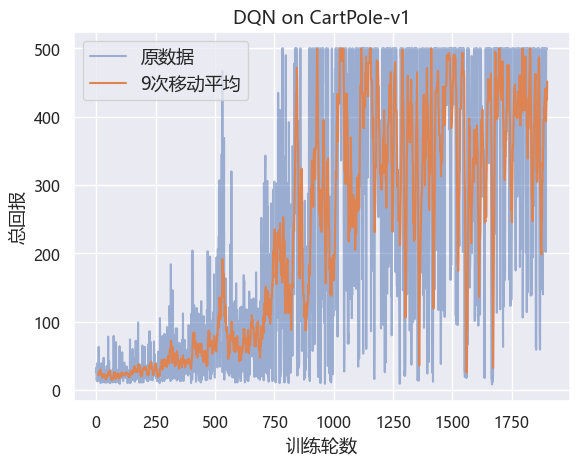

<20/20>:   0%|          | 0/100 [00:00<?, ?it/s]

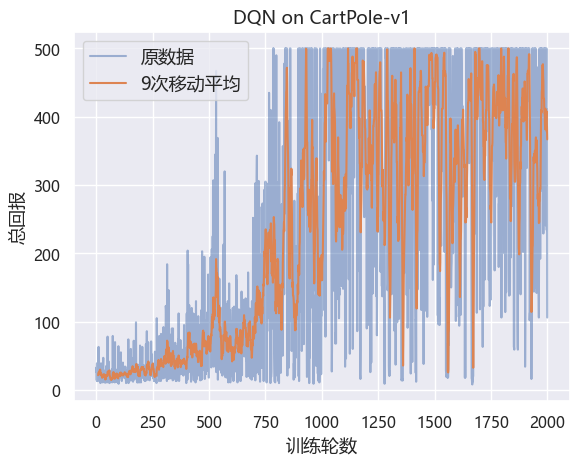

<All keys matched successfully>

In [9]:
for epoch in range(s_epoch, total_epoch):
    with tqdm(total=total_episode, desc='<%d/%d>'%(epoch+1, total_epoch), leave=False) as pbar:
        for episode in range(total_episode):
            episode_return = 0
            state = env.reset()[0]
            done = truncated = False
            step = 0
            while (not (done | truncated)) and step < max_step:  # 执行单次游戏, 最多max_step步
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done, truncated)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if len(replay_buffer.buffer) > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d,
                        'truncated': b_t
                    }
                    agent.update(transition_dict)  # 获得经验中抽取的样本, 拟合网络并且梯度上升
                    step += 1 # 步数加一
                    
                    # 获得最佳权重
                    if episode_return > best_score:
                        best_weight = agent.q_net.state_dict()
                        best_score = episode_return
                    
            return_list.append(episode_return)
            
            if (episode + 1) % 10 == 0:  # 显示过去10次游戏情况
                pbar.set_postfix({
                    'train_times':
                    '%d' % (total_episode * epoch + episode + 1),  # 至今一共训练了多少次游戏
                    'recent_reward':
                    '%.1f' % np.mean(return_list[-10:]),
                    'episilon':
                    '%.2f' % agent.epsilon
                })
                
            # 调整epsilon
            agent.epsilon = max(1 - epoch / (total_epoch / 2), 0.01)
            
            # 保存检查点
            # 在训练过程中保存检查点：
            data_to_save = {
                'epoch': epoch,
                'episode': episode,
                'best_weight': best_weight,
                'epsilon': epsilon,
                'return_list': return_list,
            }
            save_ckp(data_to_save, CKP_PATH)
            pbar.update(1)  # 更新进度条
    rl_utils.picture_return(return_list, 'DQN', env_name, 9)#每一轮训练就画一次图
print()
agent.q_net.load_state_dict(best_weight)  # 应用最佳权重

### 绘图

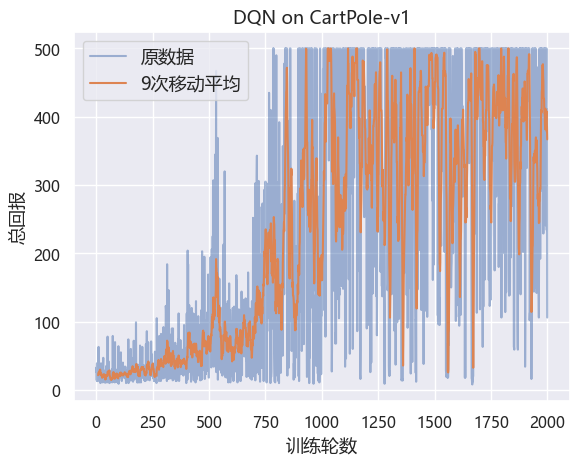

In [10]:
rl_utils.picture_return(return_list, 'DQN', env_name, 9)

### 疑难：1200次数左右出现大幅度下降：
对于DQN (Deep Q-learning Network) 在CartPole这类任务中，有几个可能的原因导致这种现象：

1. **探索与利用的平衡**：在某些时刻，算法可能会更多地进行探索而不是利用已知的最佳策略，这可能导致性能下降。这是由于ε-greedy策略，其中ε是探索率，决定了算法选择随机行动的概率。如果在这个时间点ε突然增加，可能会导致更多的探索，从而性能下降。

2. **学习率的变化**：如果使用的学习率太高或在训练过程中不适当地调整，它可能导致Q值的估计在某些时刻不稳定，从而影响性能。

3. **经验回放的问题**：DQN使用经验回放来随机抽取以前的经验进行学习。如果回放缓冲区中的某些经验导致了不良的学习或模型的不稳定，这可能会影响性能。

4. **模型网络的不稳定**：神经网络有时可能会进入不稳定的状态，尤其是当它尝试逼近非线性函数时。这可能导致学习的不稳定性。

5. **任务的困难度突然增加**：虽然这在CartPole任务中不太可能，但有时环境的难度可能会突然增加，导致性能下降。

### |图像为输入的 DQN 算法
#### 加入卷积层
```python
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)
```
#### 其余略

### |总结：
本章讲解了 DQN 算法，其主要思想是用一个神经网络来表示最优策略的函数，然后利用 Q-learning 的思想进行参数更新。为了保证训练的稳定性和高效性，DQN 算法引入了经验回放和目标网络两大模块，使得算法在实际应用时能够取得更好的效果。在 2013 年的 NIPS 深度学习研讨会上，DeepMind 公司的研究团队发表了 DQN 论文，首次展示了这一直接通过卷积神经网络接受像素输入来玩转各种雅达利（Atari）游戏的强化学习算法，由此拉开了深度强化学习的序幕。DQN 是深度强化学习的基础，掌握了该算法才算是真正进入了深度强化学习领域，本书中还有更多的深度强化学习算法等待读者探索。

---

### |附录：
1. `torch.manual_seed(0)`设定随机数种子，确保可重复性
2. 列张量.view(-1,1)和.gather()方法：
    q_sa =[[0.2, 0.4, 0.3],
         [0.5, 0.3, 0.1],
         [0.4, 0.2, 0.6]]
    action = action.view(-1,1)
    [[0.4],
    [0.5],
    [0.6]]
    
    q_sa.gether(1,action.view(-1,1))
    [[0.4],
    [0.5],
    [0.6]]
   self.q_net(states)返回一个形状为[batch_size, action_dim]的张量，现在根据每一个s对应的action来选取qsa，则必须要求action必须是列向量
   .view(-1,1)能够在不改变原值的基础上，返回shape改变后的张量
   .gether()@param dim=<int> @param <Tensor>

3. .max(1)最大值方法
    @param dim=<int>指定在哪一个维度寻找
    .max(1)[0] 返回每行的最大值
    .max(1)[1] 返回每行最大值的索引

4. torch.mean(...)计算所有张量的平均值
    
---



#### |为何均方误差 (MSE)损失函数使用1/2公式
在深度学习和强化学习中，Q网络（或者更广泛地说，神经网络）的损失函数经常包含一个$\frac{1}{2}$系数。这主要是出于数学上的便利性。

为了更好地理解这一点，考虑一个简单的均方误差损失函数：
$$
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y_i})^2
$$

当我们对其进行微分，以计算关于$\hat{y_i}$的梯度时，我们得到：
$$
\frac{\partial L}{\partial \hat{y_i}} = \frac{2}{N} (y_i - \hat{y_i})
$$

但是，如果我们在损失函数前面加上一个$\frac{1}{2}$系数：
$$
L = \frac{1}{2N} \sum_{i=1}^{N} (y_i - \hat{y_i})^2
$$

其梯度则为：
$$
\frac{\partial L}{\partial \hat{y_i}} = \frac{1}{N} (y_i - \hat{y_i})
$$

这样，我们得到了一个更加简洁的梯度表达式。尽管乘以$\frac{1}{2}$并不会改变损失函数的最优值位置，但它可以使梯度的计算更为简单和直观。这在实际的优化中很有用，因为神经网络的训练通常涉及大量的梯度计算。

---

#### |激活函数：
神经网络是线性模型，多层以后$g(f(x))=c(ax+b)+d=acx+(bc+d)$还是线性模型，为此需要在层之间使用激活函数，否则神经网络仍然是一个线性变换，为此需要引入非线性——这就是激活函数的作用：
常见的激活函数，如 Sigmoid、ReLU 和 Tanh，都是非线性的，其中最常见的为：**ReLU（Rectified Linear Unit）**是深度学习中最常用的激活函数之一：
$$f(x)=max(0,x)$$
- ReLU优点:在正数范围内是线性的，训练时相对更快更有效，并且不太可能饱和（在某些区域梯度接近于零，导致训练停滞）
- ReLU也有称为“死神经元”缺点:某些神经元可能会停止更新，因为它们的输出始终为零

---

#### |torch.nn神经网络
`Qnet` 类定义一个简单的 **前馈神经网络（Feed-forward Neural Network）**：
该网络具有一个隐藏层，并用于Q-learning
```python
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    ....
```
1. **输入层**：
    - 输入向量维度`state_dim`环境的状态有多少个特征/维度

2. **隐藏层**：
    - 全连接层，其输入维度为 `state_dim`，输出维度为 `hidden_dim`
    - 这一层后面跟着ReLU激活函数，为网络引入非线性

3. **输出层**：
    - 又是一个全连接层，其输入维度为 `hidden_dim`，输出维度为`action_dim`
    `action_dim` 表示在给定状态下每个可能的动作的Q值

> 缺失图片一张

1. Input 1-4: 这四个节点代表输入状态的四个维度。
2. Hidden 1-5 (fc1): 这五个节点代表fc1层的输出，即隐藏层的神经元。
3. ReLU 1-5: 这五个节点代表ReLU激活函数的输出。这个函数是直接应用在fc1层的输出上的(通常ReLU会被省略，因为是紧跟在fc1的后面的)
4. Output 1-2 (fc2): 这两个节点代表fc2层的输出，即对应于两个可能动作的Q值。

---

#### |ReLU激活函数->forward前向传播：
```python
    ...
    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)
```
1. `self.fc1(x)`输入x首先通过self.fc1，这是一个全连接层,这可以看作是模型的第一个转换
2. `F.relu()`ReLU激活函数被应用于self.fc1的输出，为模型引入非线性
3. `return self.fc2(x)`最后，经ReLU激活的输出给fc2，这是另一个全连接层

实例化模型并想要获得某个输入的输出，不直接调用forward()，只需调用模型实例：
```python
model = Qnet(state_dim, hidden_dim, action_dim)
output = model(input_data)
```
内部会调用了forward()方法

---

#### |使用Adam优化器
Adam优化器，用于调整Qnet模型的参数以最小化损失函数。
优化器用于更新网络的权重和偏置，从而改进模型的预测能力：
```python
    # 使用Adam优化器
    self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                           lr=learning_rate)
```
1. torch.optim.Adam: Adam是一种常用的优化算法，它结合了两种扩展的随机梯度下降方法：AdaGrad和RMSProp。Adam通常被认为是对许多问题都表现良好的算法。

2. self.q_net.parameters(): 这返回Qnet模型中所有的可训练参数（即权重和偏置）。这告诉优化器哪些参数需要更新。

3. lr=learning_rate: 这定义了学习率，它决定了参数更新的步长。较高的学习率可能导致模型收敛得更快，但也可能导致模型在最优解附近震荡。较低的学习率可能导致模型收敛得更慢。

```python 
loss.backward()  # 计算损失关于模型参数的梯度
self.optimizer.step()  # 使用梯度更新模型参数
```
---

#### |计算损失函数
均方误差 (MSE)损失函数
```python
dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
```
1. **`F.mse_loss(q_values, q_targets)`**:
    - `F` 是PyTorch中的`torch.nn.functional`模块，它包含了许多神经网络的功能，包括损失函数。
    - `mse_loss` 是均方误差损失函数。它计算了两个张量之间的均方误差。具体地说，对于每个元素，它计算了`q_values`和`q_targets`之间的差的平方，然后取平均值。
    - `q_values` 是模型为当前状态和动作预测的Q值。
    - `q_targets` 是这些Q值的目标或期望值，通常基于奖励和下一个状态的最大Q值计算得到。

2. **`torch.mean(...)`**:
    - 该函数计算其输入张量的所有元素的平均值。在这种情况下，它实际上是多余的，因为`F.mse_loss`已经返回了一个标量值（均方误差的均值）。所以，对其使用`torch.mean`并不会改变其值。
    - 但在某些情况下，例如当使用`reduction='none'`参数时，`F.mse_loss`可能会返回一个非标量张量。在这种情况下，使用`torch.mean`可以确保你得到一个标量损失值。
    
---

#### |梯度&反向传播算法
当我们说模型的"训练"，本质上我们指的是优化模型的参数以使模型的预测尽可能接近真实的目标值。为了实现这一目标，我们使用梯度下降或其变体来逐渐调整模型的参数：
1. **反向传播算法 (Backpropagation)**:
    - 这是一个用于计算损失函数关于模型参数的梯度的算法。换句话说，它告诉我们损失函数是如何随模型的每个参数的微小变化而变化的
    - 梯度告诉我们如何更改模型的参数以减少损失

2. **参数的`.grad`属性**:
    - 在PyTorch中，每个模型参数（通常是一个张量）都有一个`.grad`属性。当你调用`.backward()`方法时，PyTorch会计算梯度并将它们存储在这个属性中
    - 模型参数`weight`，在调用`.backward()`之后，`weight.grad`将包含损失函数关于这个权重的梯度

3. **使用梯度来更新模型参数**:
    - 一旦我们有了梯度，我们就可以使用它们来更新模型的参数。具体地说，我们会按照梯度的方向调整每个参数，以尝试减少损失
    - 这是通过优化器（例如SGD、Adam等）来完成的，它根据计算的梯度和其他参数（如学习率）来决定如何更新模型的参数

---

#### |神经网络训练的典型步骤 I：
```python
dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) # 均方误差损失函数
self.optimizer.zero_grad()  
# PyTorch中默认梯度会累积,这里需要显式将梯度置为0
dqn_loss.backward()# 反向传播更新参数
self.optimizer.step()
```
1. **`self.optimizer.zero_grad()`**:
    - 在PyTorch中，当你调用`.backward()`方法时，梯度是累积的，这意味着每次计算梯度，它都会被添加到之前的梯度上，而不是替换它们
    - 因此，每次开始新的优化步骤之前，你需要将之前的梯度清零。这就是`zero_grad()`方法的作用
    - 如果不这样做，你的模型可能会在某些情况下发散或不收敛，因为它会累积过去所有的梯度，而不仅仅是最新的梯度

2. **`dqn_loss.backward()`**:
    - 这行代码负责计算损失关于模型参数的梯度
    - `backward()`方法执行反向传播算法，它计算了损失函数关于每个参数的梯度，并将这些梯度存储在参数的`.grad`属性中。
    - 这些计算的梯度将被用于更新模型的权重

3. **`self.optimizer.step()`**:
    - 这行代码使用之前计算的梯度来更新模型的权重
    - 当你调用一个优化器（在这里是`self.optimizer`，它可能是一个Adam、SGD等优化器）的`.step()`方法时，它会按照该优化器的规则（如学习率、动量等）更新模型的所有权重
    - 这是神经网络训练的核心步骤，因为它使模型逐渐适应数据，从而减少预测错误

---

#### |更新目标网络
用两个方法来更新主Q网络和目标Q网络
```python
if self.count % self.target_update == 0:
    self.target_q_net.load_state_dict(
        self.q_net.state_dict())  # 更新目标网络
self.count += 1  
```
1. 检查self.count是否已经达到更新的次数要求
2. `.state_dict()`获取权重&偏置
3. `.load_state_dict(..)`将这些权重和偏置加载

---

#### |epoch & episode 完整的训练&完整交互序列
```python
for epoch in range(s_epoch, total_epoch):
    for episode in range(total_episode):
```
在强化学习中，一个epoch通常代表一个完整的训练过程，而episode代表从环境的初始状态开始到达终止状态的完整交互序列
1. 每个episode都为代理提供了一个新的机会来探索环境并学习如何最大化其回报
2. 通过多个episode，代理可以学习到环境的各种可能变化

---

#### |minimal_size最小开始训练数据量
深度Q网络（DQN）和其他使用回放缓冲区的强化学习算法中，等待回放缓冲区达到一定的大小再开始训练：
```python
# 当buffer数据的数量超过一定值后,才进行Q网络训练
if len(replay_buffer.buffer) > minimal_size:
            #👆.buffer方法属实比较奇怪
    b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(batch_size)
```
**多样性**：当回放缓冲区较小时，它可能只包含非常有限的经验，这可能导致代理在一个很小的经验子集上过度拟合。等待缓冲区填充到一个较大的大小可以确保有足够的多样性，从而训练更稳健的策略

---

